In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from lib.utility_functions import *
from lib.exp4 import *

sns.set_style('white')
sns.set_context('paper')

colors = sns.color_palette().as_hex()

pd.set_option('display.max_columns', 40)

% matplotlib inline

In [2]:
tidy = pd.read_csv('./tidy_data.csv', index_col=0)
tidy['Condition'] = tidy['Condition'].map(lambda x: 'Untrained' if x == 'Naive' else x)

tidy['Num Dif'] = tidy['Num Pieces (final)'] - tidy['Num Pieces']
tidy.head()

,Subject ID,Condition,Game Index,Position ID,Is Real,Black Position,White Position,Black Position (final),White Position (final),Response Time,Num Black Pieces,Num White Pieces,Num Pieces,Total Black Errors,Total White Errors,Total Errors,Type I Errors (black),Type I Errors (white),Type I Errors,Type II Errors (black),Type II Errors (white),Type II Errors,Type III Errors (black),Type III Errors (white),Type III Errors,Num Pieces (final),Numerosity Error,Num Dif
0,1464109333721,Trained,0,25.0,False,000000000011010000010100000001010001,001100000000001000001000000010100010,000000000011010000010100100001000000,000100000000100010001011000000000100,43.957,8,7,15,3,10,13.0,1,5,6,2,5,7,0,0,0,14,1,-1
2,1464109333721,Trained,1,92.0,True,001011000000011000000101000000010100,000100000001100100000010100001101000,000001000001011000000101000000010100,000100000000100100001010100000101000,36.897,9,9,18,3,3,5.0,0,1,1,2,1,3,0,1,1,16,2,-2
4,1464109333721,Trained,2,16.0,False,100100000001010000000100000000101000,000010000010000100001001000001000000,100100000001010000000101000000100000,000001000010000100001000000000000000,17.922,7,6,13,2,4,5.0,0,1,1,1,2,3,0,1,1,11,2,-2
6,1464109333721,Trained,3,75.0,True,000001001000101100001001000000010000,000100000001010000010110000000001000,000001001001001100000101000000010000,000100000000110000000010000000001000,22.380,8,7,15,4,4,5.0,0,0,0,1,1,2,1,2,3,13,2,-2
8,1464109333721,Trained,4,69.0,True,000101000101100000001100000000000000,000000000010011000000001000000111000,000101000101100000001100000000000000,000000000010011000000001000000111000,20.494,7,7,14,0,0,0.0,0,0,0,0,0,0,0,0,0,14,0,0


In [3]:
mean_piv = tidy.pivot_table(
    index='Subject ID', values='Total Errors', columns=['Is Real', 'Num Pieces']
)

mean_piv['Condition'] = mean_piv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])

std_piv = tidy.pivot_table(
    index='Subject ID', values='Total Errors', columns=['Is Real', 'Num Pieces'],
    aggfunc=np.std
)

std_piv['Condition'] = mean_piv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])

In [4]:
c_filter = mean_piv['Condition'] == 'Trained'

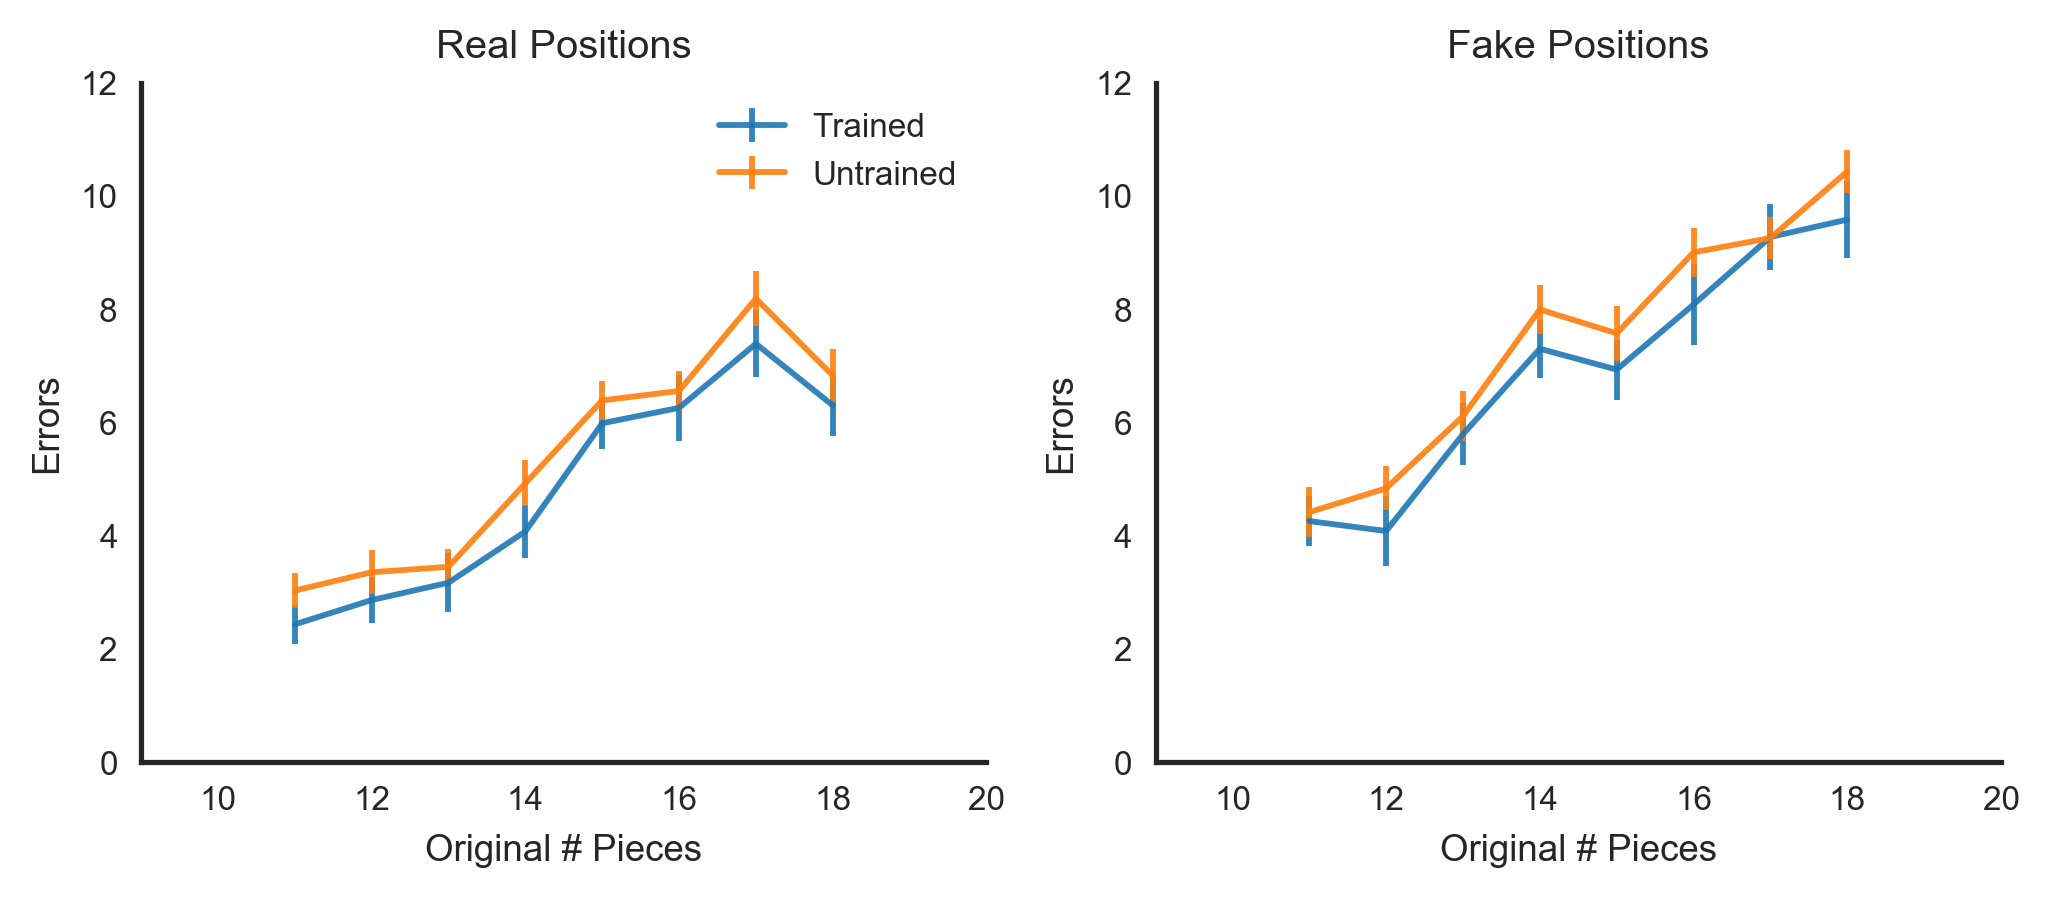

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

tc_filter = tidy['Condition'] == 'Trained'
tp_filter = tidy['Is Real'] == True


def errbar_plot(df, ax, **kwargs):
    piv = df.pivot_table(
        index='Subject ID', values='Total Errors', columns='Num Pieces'
    )
    
    x = piv.columns.values
    y = piv.mean(axis=0)
    err = piv.std() / np.sqrt(len(piv))

    ax.errorbar(x, y, yerr=err, **kwargs)
    
    return None


## Real

ax = axes[0]

#### Trained

errbar_plot(
    tidy.loc[tc_filter & tp_filter], 
    ax=ax, color=colors[0], alpha=.9, label='Trained'
)

#### Untrained

errbar_plot(
    tidy.loc[~tc_filter & tp_filter],
    ax=ax, color=colors[1], alpha=.9, label='Untrained'
)


## Fake

ax = axes[1]

#### Trained

errbar_plot(
    tidy.loc[tc_filter & ~tp_filter], 
    ax=ax, color=colors[0], alpha=.9, label='Trained'
)

#### Untrained

errbar_plot(
    tidy.loc[~tc_filter & ~tp_filter],
    ax=ax, color=colors[1], alpha=.9, label='Untrained'
)

## Make it fancy

# axes[0].plot(np.arange(20), color='grey')
# axes[1].plot(np.arange(20), color='grey')

axes[0].legend(loc=0)

plt.setp(
    axes, 
    ylabel='Errors', xlabel='Original # Pieces', 
    xlim=[9, 20], ylim=[0, 12],
#     xticks=np.arange(11, 19, 1), xticklabels=np.arange(11, 19, 1),
#     yticks=np.arange(9, 20, 1), yticklabels=np.arange(9, 20, 1)
)
plt.setp(axes[0], title='Real Positions')
plt.setp(axes[1], title='Fake Positions')

sns.despine()

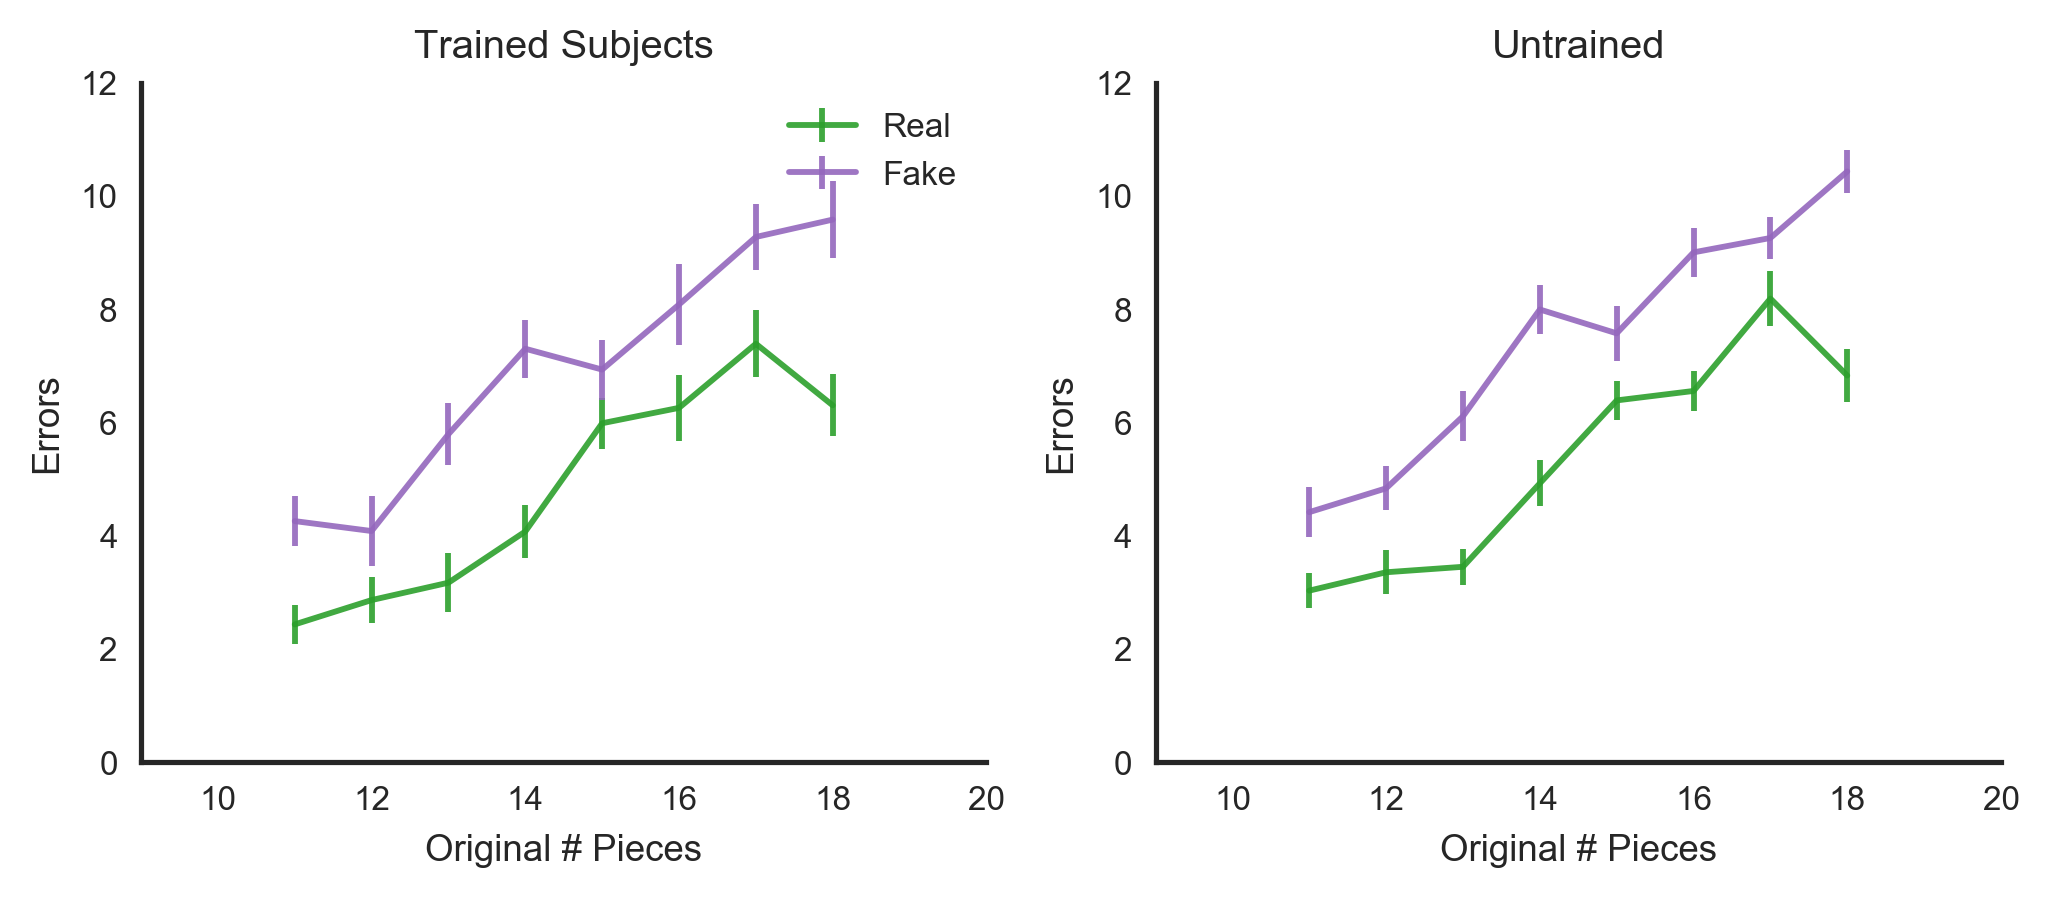

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

tc_filter = tidy['Condition'] == 'Trained'
tp_filter = tidy['Is Real'] == True


def errbar_plot(df, ax, **kwargs):
    piv = df.pivot_table(
        index='Subject ID', values='Total Errors', columns='Num Pieces'
    )
    
    x = piv.columns.values
    y = piv.mean(axis=0)
    err = piv.std() / np.sqrt(len(piv))

    ax.errorbar(x, y, yerr=err, **kwargs)
    
    return None


## Trained

ax = axes[0]

#### Real

errbar_plot(
    tidy.loc[tc_filter & tp_filter], 
    ax=ax, color=colors[2], alpha=.9, label='Real'
)

#### Fake

errbar_plot(
    tidy.loc[tc_filter & ~tp_filter],
    ax=ax, color=colors[4], alpha=.9, label='Fake'
)


## Untrained

ax = axes[1]

#### Trained

errbar_plot(
    tidy.loc[~tc_filter & tp_filter], 
    ax=ax, color=colors[2], alpha=.9, label='Real'
)

#### Untrained

errbar_plot(
    tidy.loc[~tc_filter & ~tp_filter],
    ax=ax, color=colors[4], alpha=.9, label='Fake'
)

## Make it fancy

# axes[0].plot(np.arange(20), color='grey')
# axes[1].plot(np.arange(20), color='grey')

axes[0].legend(loc=0)

plt.setp(
    axes, 
    ylabel='Errors', xlabel='Original # Pieces', 
    xlim=[9, 20], ylim=[0, 12],
#     xticks=np.arange(11, 19, 1), xticklabels=np.arange(11, 19, 1),
#     yticks=np.arange(9, 20, 1), yticklabels=np.arange(9, 20, 1)
)
plt.setp(axes[0], title='Trained Subjects')
plt.setp(axes[1], title='Untrained')

sns.despine()

In [7]:
tidy.head()

,Subject ID,Condition,Game Index,Position ID,Is Real,Black Position,White Position,Black Position (final),White Position (final),Response Time,Num Black Pieces,Num White Pieces,Num Pieces,Total Black Errors,Total White Errors,Total Errors,Type I Errors (black),Type I Errors (white),Type I Errors,Type II Errors (black),Type II Errors (white),Type II Errors,Type III Errors (black),Type III Errors (white),Type III Errors,Num Pieces (final),Numerosity Error,Num Dif
0,1464109333721,Trained,0,25.0,False,000000000011010000010100000001010001,001100000000001000001000000010100010,000000000011010000010100100001000000,000100000000100010001011000000000100,43.957,8,7,15,3,10,13.0,1,5,6,2,5,7,0,0,0,14,1,-1
2,1464109333721,Trained,1,92.0,True,001011000000011000000101000000010100,000100000001100100000010100001101000,000001000001011000000101000000010100,000100000000100100001010100000101000,36.897,9,9,18,3,3,5.0,0,1,1,2,1,3,0,1,1,16,2,-2
4,1464109333721,Trained,2,16.0,False,100100000001010000000100000000101000,000010000010000100001001000001000000,100100000001010000000101000000100000,000001000010000100001000000000000000,17.922,7,6,13,2,4,5.0,0,1,1,1,2,3,0,1,1,11,2,-2
6,1464109333721,Trained,3,75.0,True,000001001000101100001001000000010000,000100000001010000010110000000001000,000001001001001100000101000000010000,000100000000110000000010000000001000,22.380,8,7,15,4,4,5.0,0,0,0,1,1,2,1,2,3,13,2,-2
8,1464109333721,Trained,4,69.0,True,000101000101100000001100000000000000,000000000010011000000001000000111000,000101000101100000001100000000000000,000000000010011000000001000000111000,20.494,7,7,14,0,0,0.0,0,0,0,0,0,0,0,0,0,14,0,0


# Negative Binomial Regression

In [8]:
tidy['x'] = tidy['Num Pieces']
tidy['y'] = tidy['Total Errors']

In [9]:
NBFam = sm.families.NegativeBinomial()

def get_nbr_params(condition='Trained', is_real=True):
    models = []
    c = tidy['Condition'] == condition
    r = tidy['Is Real'] == is_real
    
    T = tidy.loc[c & r]
    
    for subject_id in T['Subject ID'].unique():
        p = T['Subject ID'] == subject_id
        S = T.loc[p]
        
        model = smf.glm(formula='y ~ x', data=S, family=NBFam).fit(method='bfgs', maxiter=10000)
        models.append(model)
        
    params = pd.DataFrame([m.params for m in models], index=T['Subject ID'].unique())
    params['Condition'] = condition
    params['Is Real'] = is_real
    
    return params, models

In [10]:
param_dfs = []
models_list = []

for condition in ['Trained', 'Untrained']:
    for is_real in [True, False]:
        param_df, models = get_nbr_params(condition=condition, is_real=is_real)
        param_dfs.append(param_df)
        models_list.append(models)
        
params = pd.concat(param_dfs)

No handles with labels found to put in legend.


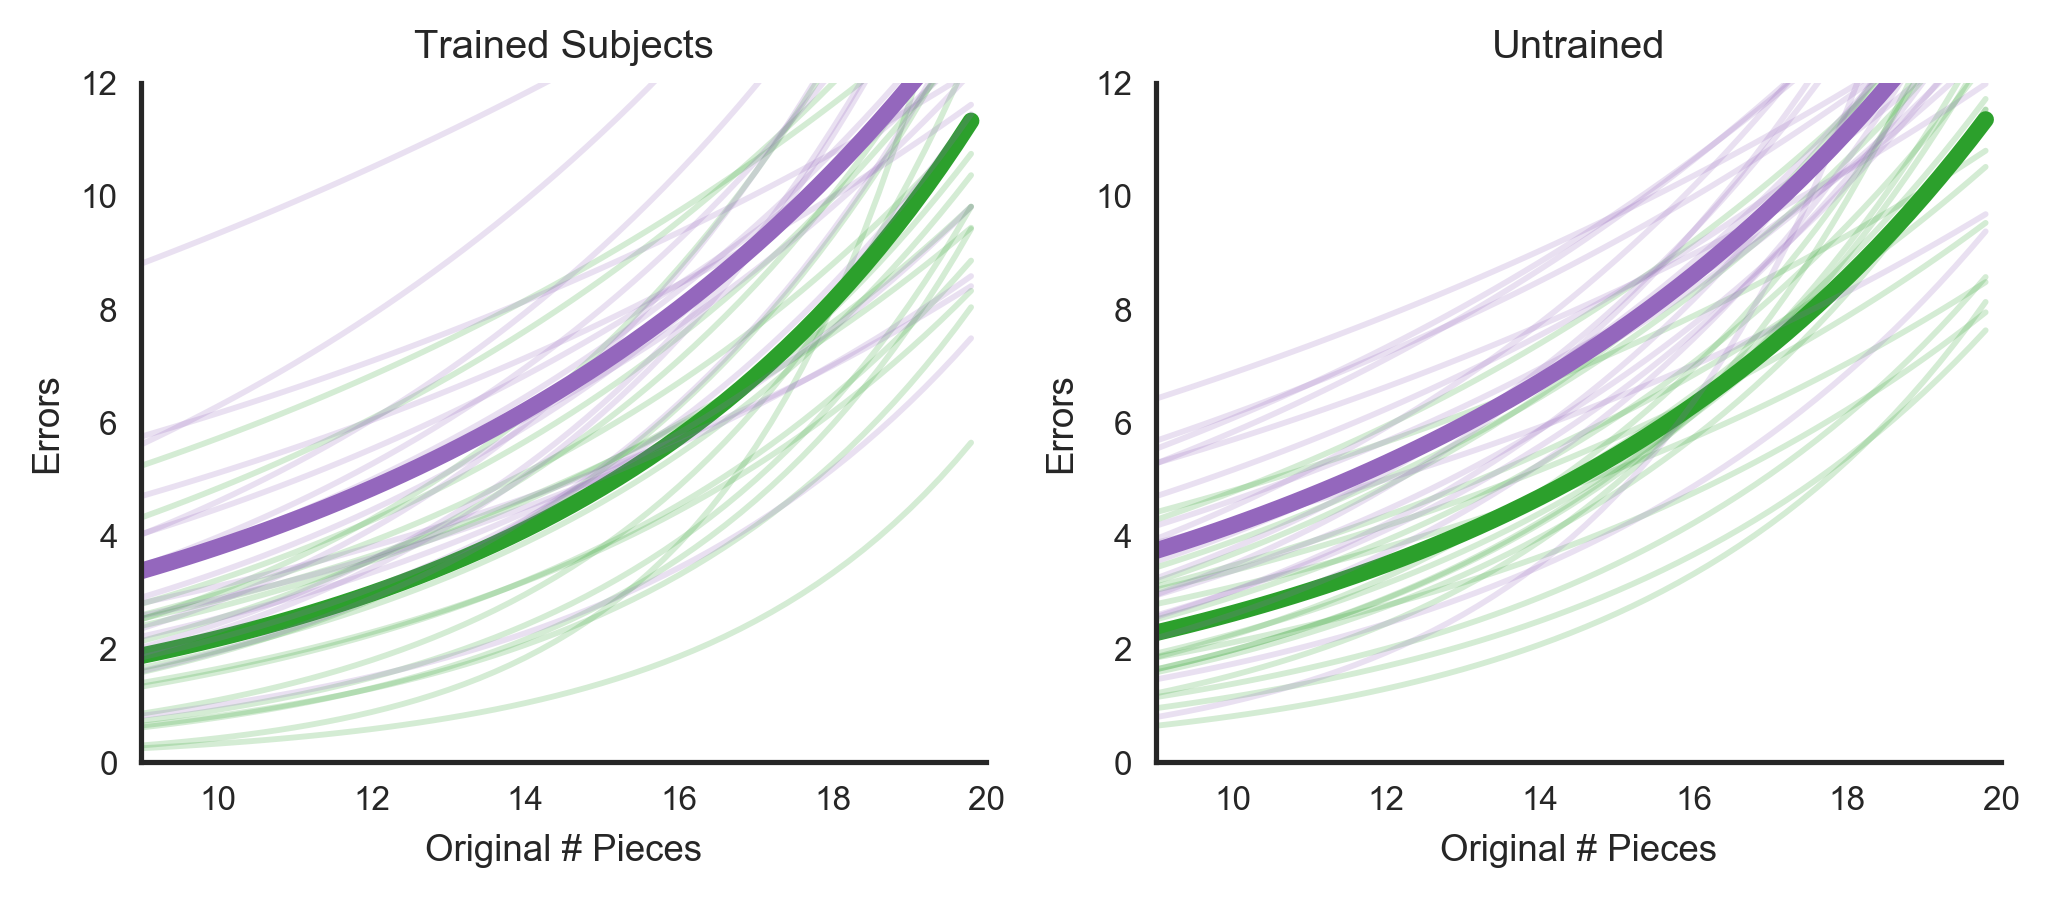

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

params_condition_filter = params['Condition'] == 'Trained'
params_position_filter = params['Is Real']


support = np.arange(0, 20, .2)


def get_fitted_lines(p):
    for row in p.iterrows():
        x = row[1]['x']
        b = row[1]['Intercept']
        
        fit = np.exp(x * support + b)
        
        yield fit        


    
# Trained 

ax = axes[0]

### Real

p = params.loc[params_condition_filter & params_position_filter]
base = np.zeros_like(support)

for l in get_fitted_lines(p):
    ax.plot(support, l, color=colors[2], alpha=.2)
    base += l
    
mean = base / len(p)

ax.plot(support, mean, color=colors[2], linewidth=4)
    
### Fake

p = params.loc[params_condition_filter & ~params_position_filter]
base = np.zeros_like(support)

for l in get_fitted_lines(p):
    ax.plot(support, l, color=colors[4], alpha=.2)
    base += l
    
mean = base / len(p)

ax.plot(support, mean, color=colors[4], linewidth=4)


# Untrained 

ax = axes[1]

### Real

p = params.loc[~params_condition_filter & params_position_filter]
base = np.zeros_like(support)

for l in get_fitted_lines(p):
    ax.plot(support, l, color=colors[2], alpha=.2)
    base += l
    
mean = base / len(p)

ax.plot(support, mean, color=colors[2], linewidth=4)
    
### Fake

p = params.loc[~params_condition_filter & ~params_position_filter]
base = np.zeros_like(support)

for l in get_fitted_lines(p):
    ax.plot(support, l, color=colors[4], alpha=.2)
    base += l
    
mean = base / len(p)

ax.plot(support, mean, color=colors[4], linewidth=4)
    

    
sns.despine()

axes[0].legend(loc=0)

plt.setp(
    axes, 
    ylabel='Errors', xlabel='Original # Pieces', 
    xlim=[9, 20], ylim=[0, 12],
#     xticks=np.arange(11, 19, 1), xticklabels=np.arange(11, 19, 1),
#     yticks=np.arange(9, 20, 1), yticklabels=np.arange(9, 20, 1)
)
plt.setp(axes[0], title='Trained Subjects')
plt.setp(axes[1], title='Untrained')

sns.despine()

In [39]:
idx_names = ['Trained', 'Untrained']
col_names = [False, True]

outputs = pd.DataFrame(index=idx_names, columns=col_names)
outputs.columns.name = 'MEAN CORRCOEF'


for idx in idx_names:
    for col in col_names:
        f_idx = tidy['Condition'] == idx
        f_col = tidy['Is Real'] == col
        g = tidy.loc[f_idx & f_col].groupby('Subject ID')
        outputs.loc[idx, col] = g.apply(lambda g_: np.corrcoef(g_['Num Pieces'].values, g_['Total Errors'].values)[0, 1]).mean()

outputs

MEAN CORRCOEF,False,True
Trained,0.495629,0.50577
Untrained,0.54561,0.495579


In [40]:
idx_names = ['Trained', 'Untrained']
col_names = [False, True]

outputs = pd.DataFrame(index=idx_names, columns=col_names)
outputs.columns.name = 'SEM CORRCOEF'


for idx in idx_names:
    for col in col_names:
        f_idx = tidy['Condition'] == idx
        f_col = tidy['Is Real'] == col
        g = tidy.loc[f_idx & f_col].groupby('Subject ID')
        corcoefs = g.apply(lambda g_: np.corrcoef(g_['Num Pieces'].values, g_['Total Errors'].values)[0, 1])
        outputs.loc[idx, col] = corcoefs.std() / np.sqrt(len(corcoefs))
outputs

SEM CORRCOEF,False,True
Trained,0.0243617,0.0229815
Untrained,0.0273177,0.02273


In [10]:
m = models_list[0][0]

In [11]:
val = 'x'

In [12]:
means = params.pivot_table(index='Condition', values=val, columns='Is Real', aggfunc=np.mean)
sems = params.pivot_table(index='Condition', values=val, columns='Is Real', aggfunc=lambda x: x.std() / np.sqrt(len(x)))

In [13]:
means.columns.name = 'MEANS'
means.index.name = None
means

MEANS,False,True
Trained,0.136474,0.189065
Untrained,0.131630,0.157252


In [14]:
sems.columns.name = 'SEMS'
sems.index.name = None
sems

SEMS,False,True
Trained,0.010131,0.015879
Untrained,0.012251,0.010148


/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/legend.py:652: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


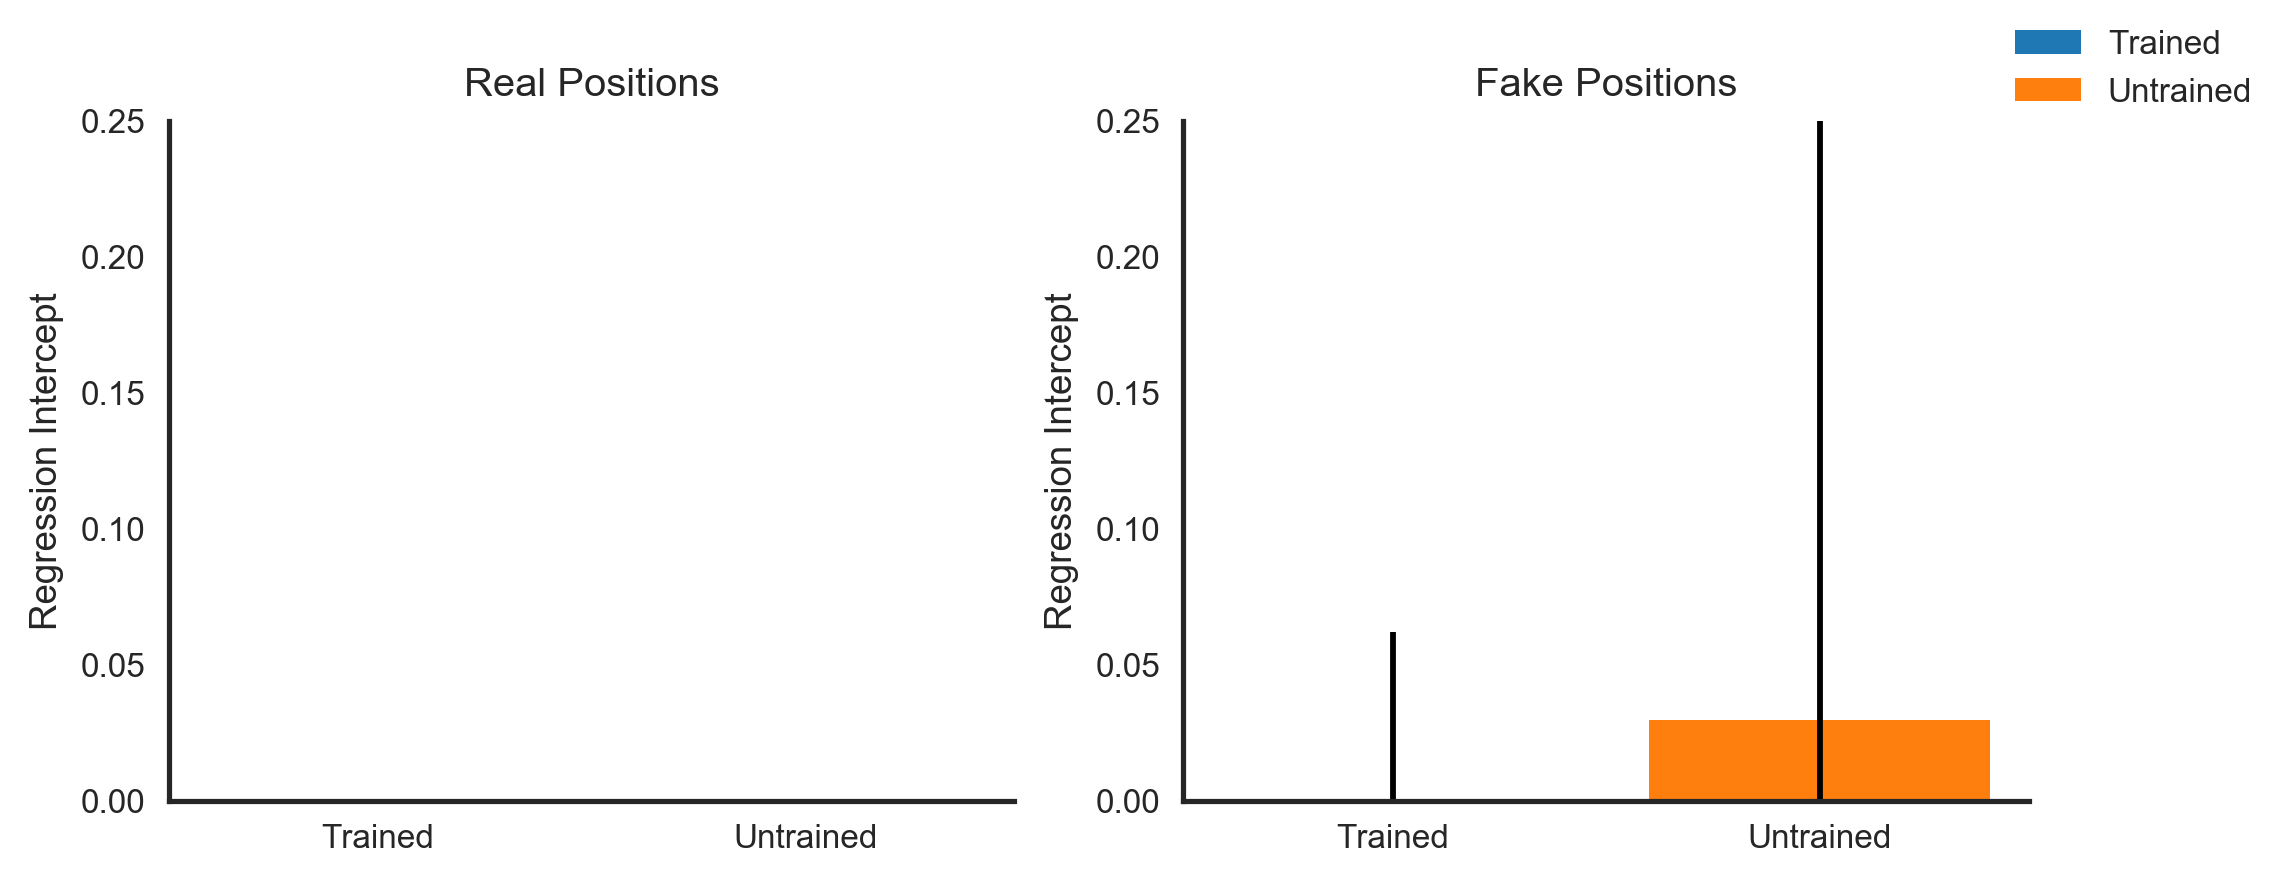

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

axes[0].bar([0], means.loc['Trained', True], color=colors[0], label='Trained')
axes[0].bar([1], means.loc['Untrained', True], color=colors[1], label='Untrained')
axes[0].errorbar([0], means.loc['Trained', True], yerr=sems.loc['Trained', True], color='black')
axes[0].errorbar([1], means.loc['Untrained', True], yerr=sems.loc['Untrained', True], color='black')

axes[1].bar([0], means.loc['Trained', False], color=colors[0])
axes[1].bar([1], means.loc['Untrained', False], color=colors[1])
axes[1].errorbar([0], means.loc['Trained', False], yerr=sems.loc['Trained', False], color='black')
axes[1].errorbar([1], means.loc['Untrained', False], yerr=sems.loc['Untrained', False], color='black')

plt.figlegend(loc=0)

plt.setp(
    axes,
    ylim=[0, .25], 
    ylabel='Regression Intercept',
    xticks=[0, 1], xticklabels=['Trained', 'Untrained']
)

plt.setp(axes[0], title='Real Positions')
plt.setp(axes[1], title='Fake Positions')

sns.despine()

In [81]:
np.exp(-.14)

0.8693582353988059

In [82]:
c = params['Condition'] == 'Trained'
r = params['Is Real'] == True

In [83]:
sts.ttest_1samp(params.loc[c & r, 'x'].values, 1)

Ttest_1sampResult(statistic=-51.070327582320374, pvalue=6.210882787999579e-21)

In [84]:
sts.ttest_1samp(params.loc[~c & r, 'x'].values, 1)

Ttest_1sampResult(statistic=-83.04269839067202, pvalue=1.0200509198260697e-24)

In [85]:
sts.ttest_1samp(params.loc[c & ~r, 'x'].values, 1)

Ttest_1sampResult(statistic=-85.23328849428839, pvalue=6.3910489955759885e-25)

In [86]:
sts.ttest_1samp(params.loc[~c & ~r, 'x'].values, 1)

Ttest_1sampResult(statistic=-70.87987041086444, pvalue=1.7499874581841753e-23)

In [87]:
pvalues = params.pivot_table(
    index='Condition', values=val, columns='Is Real', 
    aggfunc=lambda x: sts.ttest_1samp(x, 0).pvalue
)

pvalues.columns.name = 'PVALUES'
pvalues.index.name = None
pvalues

PVALUES,False,True
Trained,0.491293,0.000701
Untrained,0.896858,0.002827


In [90]:
results = pd.DataFrame()

results.loc['Condition', 'True'] = sts.ttest_ind(params.loc[c & r, val].values, params.loc[~c & r, val].values).pvalue
results.loc['Condition', 'False'] = sts.ttest_ind(params.loc[c & ~r, val].values, params.loc[~c & ~r, val].values).pvalue

results.loc['Position Type', 'Trained'] = sts.ttest_ind(params.loc[c & r, val].values, params.loc[c & ~r, val].values).pvalue
results.loc['Position Type', 'Untrained'] = sts.ttest_ind(params.loc[~c & r, val].values, params.loc[~c & ~r, val].values).pvalue

In [91]:
results.columns.name = 'PVALUES\tConstant'
results.index.name = 'Variable'
results

PVALUES Constant,True,False,Trained,Untrained
Variable,,,,
Condition,0.107458,0.569716,NaN,NaN
Position Type,NaN,NaN,0.003945,0.020492


In [23]:
sts.ttest_ind(params.loc[c & r, 'x'].values, params.loc[c & ~r, 'x'].values)

Ttest_indResult(statistic=2.7921159892478187, pvalue=0.008330295407189903)

In [24]:
sts.ttest_ind(params.loc[~c & r, 'x'].values, params.loc[~c & ~r, 'x'].values)

Ttest_indResult(statistic=1.6106032519380187, pvalue=0.11600095607732964)